Code for road classifier for CSC420 Project, with reference to https://github.com/Project-MONAI/tutorials/blob/main/2d_segmentation/torch/unet_training_dict.py


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
!pip install Pillow
!pip install monai

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
mkdir: cannot create directory ‘out’: File exists
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached monai-1.1.0-202212191849-py3-none-any.whl (1.2 MB)


In [4]:
import glob
import os
import pickle
import time

import nibabel as nib
import matplotlib.pyplot as plt
from monai.config import print_config
from monai.data import Dataset, CacheDataset, DataLoader, write_nifti, decollate_batch
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, DiceFocalLoss, GeneralizedDiceLoss, TverskyLoss
from monai.metrics import compute_hausdorff_distance, compute_dice, DiceMetric, get_confusion_matrix, HausdorffDistanceMetric, compute_average_surface_distance
from monai.networks.layers import Norm
from monai.networks.nets import UNet, AttentionUnet
import monai.transforms as tf
from monai.utils import get_torch_version_tuple, set_determinism
import pandas as pd
import torch
import numpy as np

In [4]:
!mkdir out

In [8]:
################################################################################
### DATA SETUP
#################################g##############################################

# change path to output directory here
out_dir = "/content/gdrive/MyDrive/CSC420_project"
print(f'Files will be saved to: {out_dir}')

# change path to data directory here. Right now it uses a different base dir
data_dir = '/content/gdrive/MyDrive/CSC420_Project/data/train'
# data_dir = os.path.join(base_dir, data_dir)

set_determinism(seed=0)
print('Loading files...')

# training files (remove validation subjects after)
train_images = sorted(glob.glob(os.path.join(data_dir, 'image_left', '*.jpg')))
train_labels = sorted(glob.glob(os.path.join(data_dir, 'gt_image_left', '*.png')))
train_files = [
    {'image': image, 'label': label}
    for image, label in zip(train_images, train_labels)
]
# print("train_file_sample: ", train_files)
# validation files
with open("/content/gdrive/MyDrive/CSC420_Project/road_val_subjects.txt") as file:
        val_subj_list = sorted([line.rstrip() for line in file])
        print(val_subj_list)

val_files = [train_file for train_file in train_files if train_file['image'].split('/')[-1][:-4] in val_subj_list]
train_files = [train_file for train_file in train_files if train_file['image'].split('/')[-1][:-4] not in val_subj_list]
print(train_files)
print(val_files)
# train_files = train_files[50:]
# !!! Added for small compilation test. Comment out for actual training.
# train_files = train_files[:4]
# val_files = val_files[:2]

print(f'Total {len(train_files)} subjects for training.')
print(f'Total {len(val_files)} subjects for validation.')

Files will be saved to: /content/gdrive/MyDrive/CSC420_project
Loading files...
['um_000001', 'um_000003', 'um_000005', 'um_000007', 'um_000014', 'um_000023', 'um_000027', 'um_000031', 'um_000032', 'um_000035', 'um_000038', 'um_000040', 'um_000050', 'um_000056', 'um_000058', 'um_000066', 'um_000074', 'um_000094', 'umm_000003', 'umm_000011', 'umm_000019', 'umm_000023', 'umm_000027', 'umm_000029', 'umm_000034', 'umm_000036', 'umm_000037']
[{'image': '/content/gdrive/MyDrive/CSC420_Project/data/train/image_left/um_000002.jpg', 'label': '/content/gdrive/MyDrive/CSC420_Project/data/train/gt_image_left/um_road_000002.png'}, {'image': '/content/gdrive/MyDrive/CSC420_Project/data/train/image_left/um_000004.jpg', 'label': '/content/gdrive/MyDrive/CSC420_Project/data/train/gt_image_left/um_road_000004.png'}, {'image': '/content/gdrive/MyDrive/CSC420_Project/data/train/image_left/um_000006.jpg', 'label': '/content/gdrive/MyDrive/CSC420_Project/data/train/gt_image_left/um_road_000006.png'}, {'imag

In [9]:

################################################################################
### DEFINE TRANSFORMS
################################################################################
from monai.data import PILReader
# train transforms
train_transforms = tf.Compose([
    tf.LoadImaged(keys=['image', 'label'], reader = PILReader(converter=lambda image: image.convert("L")), image_only=True,),
    tf.EnsureChannelFirstd(keys=['image', 'label']),
    tf.AsDiscreted(keys=['label'], threshold=1),
    tf.Rotate90d(keys=['image', 'label'], k=3, spatial_axes=(0, 1)),
    tf.Resized(keys=['image', 'label'], spatial_size=(320, 1200)),
    # tf.RandCropByPosNegLabeld(keys=['image', 'label'], label_key='label', spatial_size=(128, 256), pos=1, neg=1, num_samples=4),
    tf.ToTensord(keys=['image', 'label']),
])
# validation and test transforms
val_transforms = tf.Compose([
    tf.LoadImaged(keys=['image', 'label'], reader = PILReader(converter=lambda image: image.convert("L")), image_only=True,),
    tf.EnsureChannelFirstd(keys=['image', 'label']),
    tf.AsDiscreted(keys=['label'], threshold=1),
    tf.Rotate90d(keys=['image', 'label'], k=3, spatial_axes=(0, 1)),
    tf.Resized(keys=['image', 'label'], spatial_size=(320, 1200)),
    tf.ToTensord(keys=['image', 'label']),
])

In [10]:
################################################################################
### DATASET AND DATALOADERS
################################################################################

# train dataset
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=0.75)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)

Loading dataset: 100%|██████████| 80/80 [00:28<00:00,  2.84it/s]


In [11]:
# valid dataset
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=0.75)
val_loader = DataLoader(val_ds, batch_size=1)

Loading dataset: 100%|██████████| 20/20 [00:07<00:00,  2.86it/s]


sample image shape: torch.Size([320, 1200]), label shape: torch.Size([320, 1200])


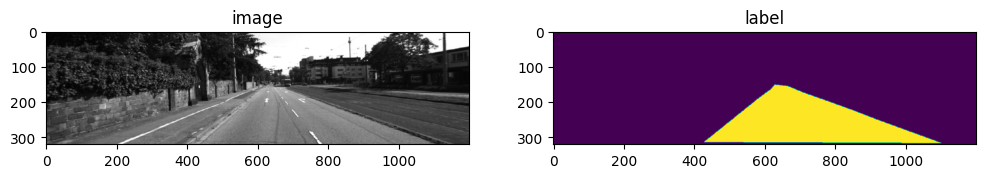

<Figure size 640x480 with 0 Axes>

In [12]:
from monai.utils import first
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"sample image shape: {image.shape}, label shape: {label.shape}")

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label)
plt.show()
plt.savefig(os.path.join('image_check.png'), bbox_inches='tight')

In [18]:

################################################################################
### MODEL AND LOSS
################################################################################

# create UNet, DiceLoss and Adam optimizer

# model = UNet(
#     spatial_dims=2,
#     in_channels=1,
#     out_channels=1,
#     channels=(16, 32, 64, 128, 256),
#     strides=(2, 2, 2, 2),
#     num_res_units=2,
# )

model = AttentionUnet(
    spatial_dims=2, 
    in_channels=1, 
    out_channels=1, 
    channels=(16, 32, 64, 128, 256), 
    strides=(2, 2, 2, 2), 
    kernel_size=3, 
    up_kernel_size=3, 
    dropout=0.1
)

# The model is trained in different sittings due to the limit of computing power
# If warm-starting is needed, load previously trained best model here
model.load_state_dict(torch.load("best_metric_model.pth"))
print(f"Loaded pretrained model.")

loss_function = DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction='mean')
post_trans = tf.Compose([tf.Activations(sigmoid=True), tf.AsDiscrete(threshold=0.5)])

################################################################################
### TRAINING LOOP
################################################################################

# Edit hyperparameters here 
epoch_num = 10
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
val_loss_values = list()
metric_values = list()

for epoch in range(epoch_num):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"], #.to(device),
            batch_data["label"] #.to(device),
        )
        # print(inputs.shape)
        # print(labels.shape)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            val_images = None
            val_labels = None
            val_outputs = None
            val_loss = 0
            metric_count = 0
            step = 0
            for val_data in val_loader:
                step += 1
                val_images, val_labels = (
                    val_data["image"], #.to(device),
                    val_data["label"], #.to(device),
                )
                # print(val_inputs.shape, val_labels.shape)

                val_outputs = model(val_images)
                loss = loss_function(val_outputs, val_labels)
                # compute metric for current iteration
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                val_loss += loss.item()

            val_loss /= step
            val_loss_values.append(val_loss)
            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model.pth")
                print("saved new best metric model")
            print(
                "current epoch: {} loss: {:.4f} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                    epoch + 1, val_loss, metric, best_metric, best_metric_epoch
                )
            )

print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")


Loaded pretrained model.
----------
epoch 1/10
1/53, train_loss: 0.1629
2/53, train_loss: 0.2161
3/53, train_loss: 0.1340
4/53, train_loss: 0.2217
5/53, train_loss: 0.1706
6/53, train_loss: 0.2238
7/53, train_loss: 0.2643
8/53, train_loss: 0.2309
9/53, train_loss: 0.1938
10/53, train_loss: 0.1171
11/53, train_loss: 0.2520
12/53, train_loss: 0.1995
13/53, train_loss: 0.1709
14/53, train_loss: 0.2016
15/53, train_loss: 0.2857
16/53, train_loss: 0.2246
17/53, train_loss: 0.2166
18/53, train_loss: 0.1118
19/53, train_loss: 0.2382
20/53, train_loss: 0.2460
21/53, train_loss: 0.1168
22/53, train_loss: 0.1062
23/53, train_loss: 0.1976
24/53, train_loss: 0.1434
25/53, train_loss: 0.2079
26/53, train_loss: 0.2060
27/53, train_loss: 0.2325
28/53, train_loss: 0.1987
29/53, train_loss: 0.1191
30/53, train_loss: 0.1740
31/53, train_loss: 0.1570
32/53, train_loss: 0.1811
33/53, train_loss: 0.2778
34/53, train_loss: 0.2228
35/53, train_loss: 0.1717
36/53, train_loss: 0.2097
37/53, train_loss: 0.1158


/usr/local/lib/python3.9/dist-packages/monai/metrics/utils.py:219: UserWarning: y should be a binarized tensor.
  warnings.warn(f"{name} should be a binarized tensor.")


saved new best metric model
current epoch: 2 loss: 0.2399 current mean dice: 0.8413 best mean dice: 0.8413 at epoch 2
----------
epoch 3/10
1/53, train_loss: 0.1445
2/53, train_loss: 0.1406
3/53, train_loss: 0.1507
4/53, train_loss: 0.1898
5/53, train_loss: 0.1848
6/53, train_loss: 0.2289
7/53, train_loss: 0.1597
8/53, train_loss: 0.2000
9/53, train_loss: 0.1293
10/53, train_loss: 0.1784
11/53, train_loss: 0.2387
12/53, train_loss: 0.1219
13/53, train_loss: 0.2272
14/53, train_loss: 0.2187
15/53, train_loss: 0.1748
16/53, train_loss: 0.2879
17/53, train_loss: 0.1614
18/53, train_loss: 0.1626
19/53, train_loss: 0.2396
20/53, train_loss: 0.2040
21/53, train_loss: 0.1553
22/53, train_loss: 0.2738
23/53, train_loss: 0.1960
24/53, train_loss: 0.2285
25/53, train_loss: 0.1996
26/53, train_loss: 0.1685
27/53, train_loss: 0.2300
28/53, train_loss: 0.2139
29/53, train_loss: 0.2385
30/53, train_loss: 0.1460
31/53, train_loss: 0.1305
32/53, train_loss: 0.1521
33/53, train_loss: 0.2166
34/53, trai

In [19]:
epoch_loss_values

[0.20010105327323632,
 0.19783889805829083,
 0.19279382902163048,
 0.19170061416096157,
 0.18434727302304021,
 0.17725317897620024,
 0.17295016293172483,
 0.16830065349737802,
 0.1618660064759078,
 0.16178033583694035]

In [20]:
val_loss_values

[0.2398942267453229,
 0.26766760481728447,
 0.2164279928913823,
 0.21153868348510177,
 0.1995765588901661]

In [21]:
metric_values

[0.841304361820221,
 0.7898032665252686,
 0.860680341720581,
 0.862609326839447,
 0.8746575117111206]

Saving training outputs to csv in output dir...
Saving validation outputs to csv in output dir...
5 2 5
Done. Finished saving files.
5 5


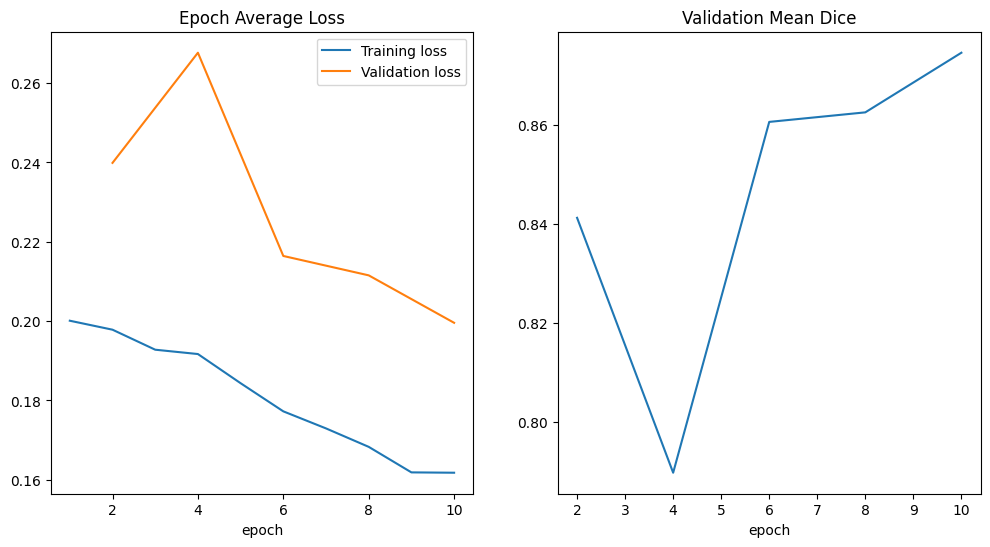

In [22]:
print('Saving training outputs to csv in output dir...')
df = pd.DataFrame(data={'train epoch num': [i + 1 for i in range(len(epoch_loss_values))], "train loss": epoch_loss_values})
df.to_csv(os.path.join('out', 'train_eval.csv'))
print('Saving validation outputs to csv in output dir...')
print(len([val_interval * (i + 1) for i in range(len(metric_values))]), len([num for idx, num in enumerate(val_loss_values) if (idx-1)%2 == 0]), len(metric_values))
df = pd.DataFrame(data={'val epoch num': [val_interval * (i + 1) for i in range(len(metric_values))], "dice": metric_values})
df.to_csv(os.path.join('out', 'val_eval.csv'))
print('Done. Finished saving files.')

################################################################################
### PLOT TRAINING CURVES
################################################################################
# plot loss and validation metric
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].set_title('Epoch Average Loss')
ax[0].set_xlabel('epoch')
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
ax[0].plot(x, y, label='Training loss')
x = [val_interval * (i + 1) for i in range(len(val_loss_values))]
y = val_loss_values
print(len(x), len(y))
ax[0].plot(x, y, label='Validation loss')
ax[0].legend()

ax[1].set_title('Validation Mean Dice')
ax[1].set_xlabel('epoch')
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
ax[1].plot(x, y)
plt.savefig('training_curves.png', bbox_inches='tight')

Loaded pretrained model.


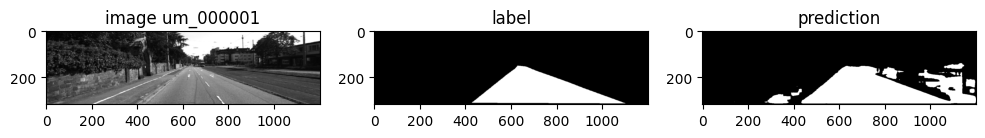

<Figure size 640x480 with 0 Axes>

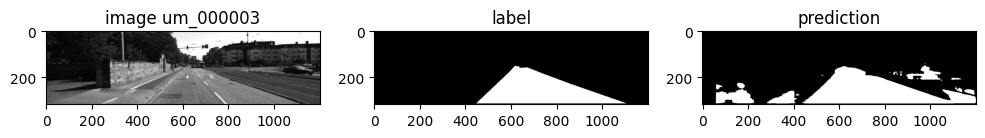

<Figure size 640x480 with 0 Axes>

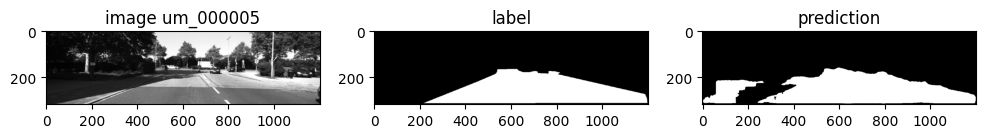

<Figure size 640x480 with 0 Axes>

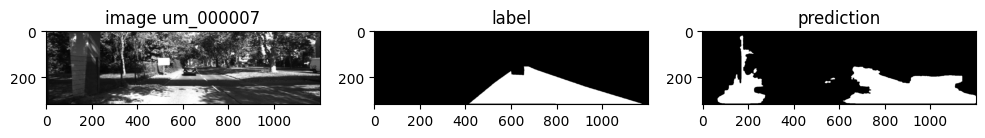

<Figure size 640x480 with 0 Axes>

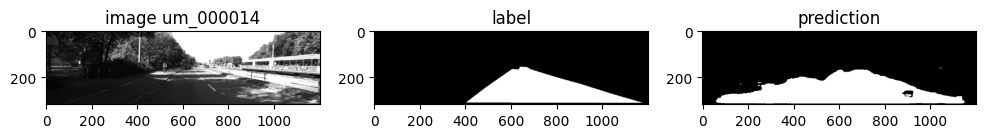

<Figure size 640x480 with 0 Axes>

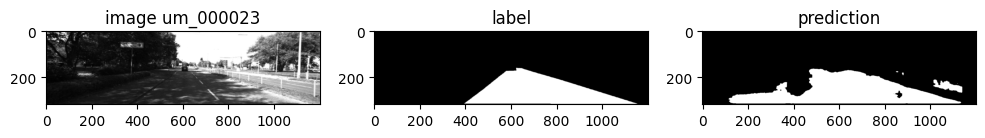

<Figure size 640x480 with 0 Axes>

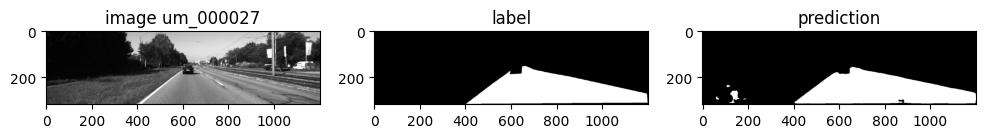

<Figure size 640x480 with 0 Axes>

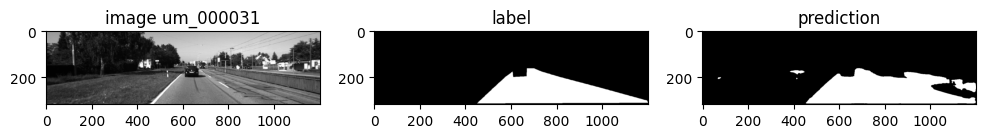

<Figure size 640x480 with 0 Axes>

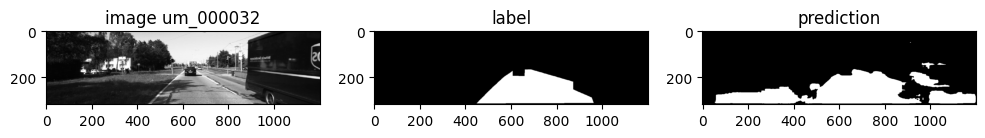

<Figure size 640x480 with 0 Axes>

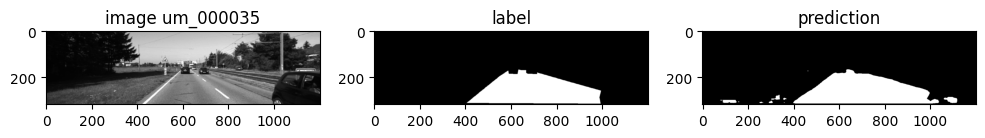

<Figure size 640x480 with 0 Axes>

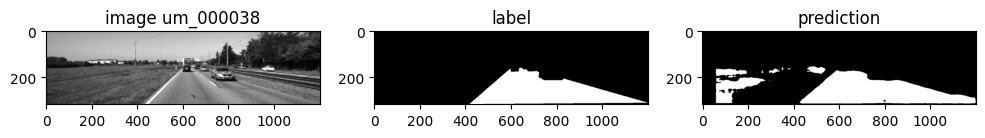

<Figure size 640x480 with 0 Axes>

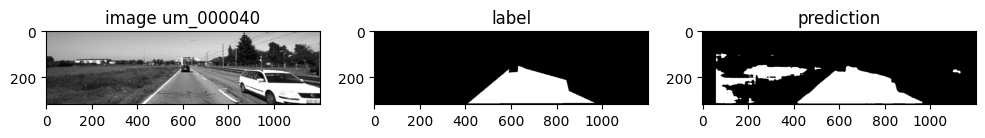

<Figure size 640x480 with 0 Axes>

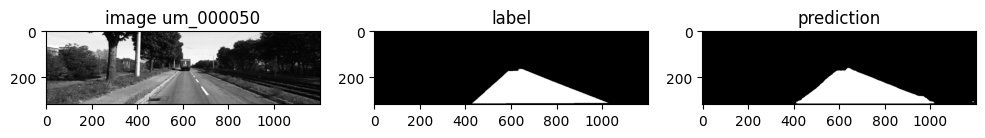

<Figure size 640x480 with 0 Axes>

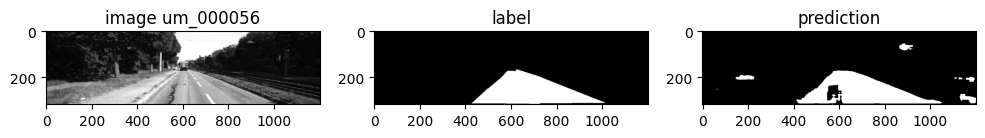

<Figure size 640x480 with 0 Axes>

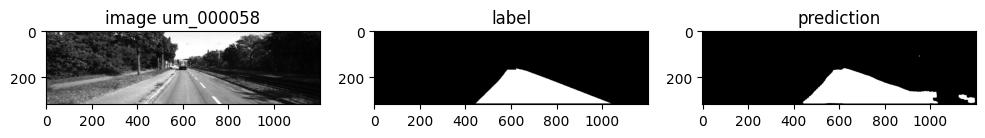

<Figure size 640x480 with 0 Axes>

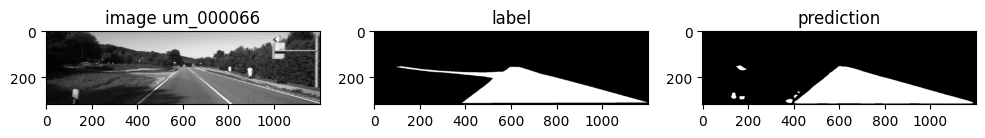

<Figure size 640x480 with 0 Axes>

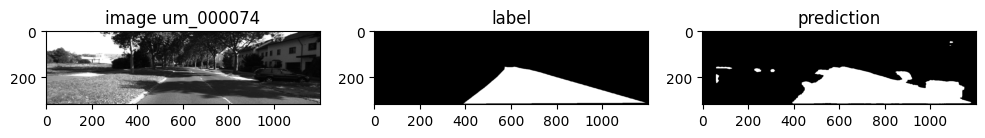

<Figure size 640x480 with 0 Axes>

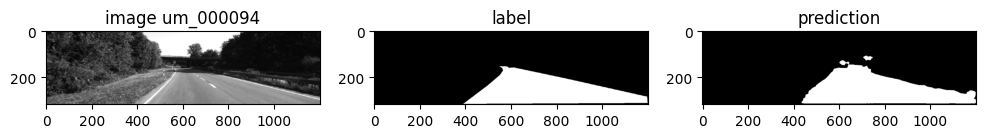

<Figure size 640x480 with 0 Axes>

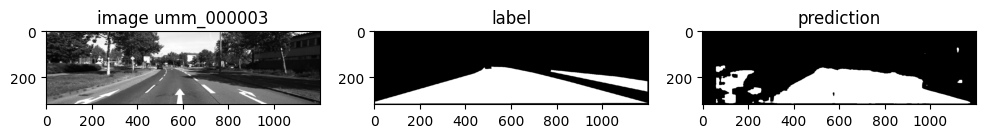

<Figure size 640x480 with 0 Axes>

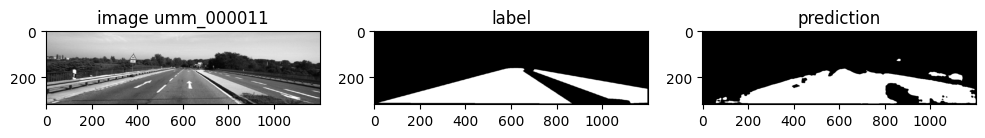

<Figure size 640x480 with 0 Axes>

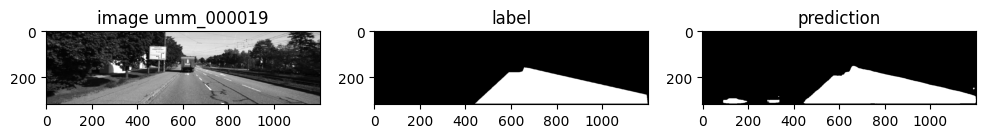

<Figure size 640x480 with 0 Axes>

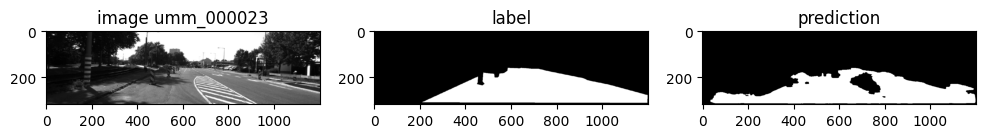

<Figure size 640x480 with 0 Axes>

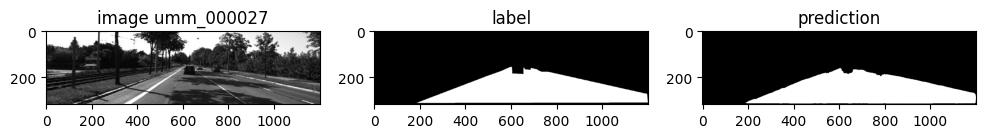

<Figure size 640x480 with 0 Axes>

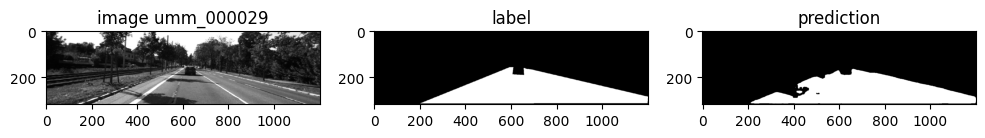

<Figure size 640x480 with 0 Axes>

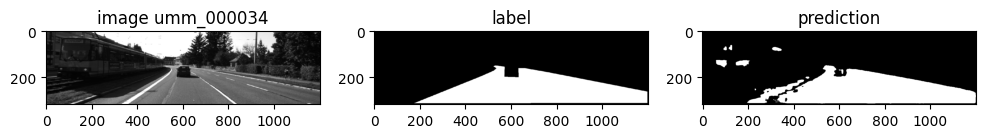

<Figure size 640x480 with 0 Axes>

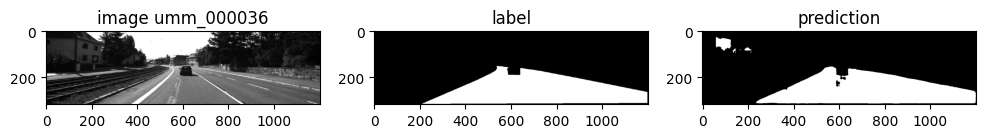

<Figure size 640x480 with 0 Axes>

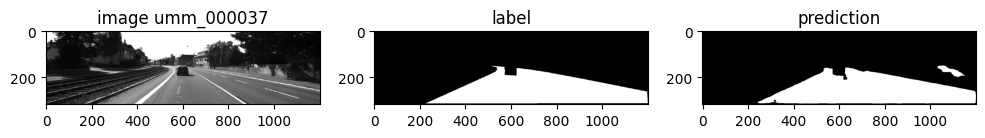

Test set mean dice: 0.8747


<Figure size 640x480 with 0 Axes>

In [26]:
model = AttentionUnet(
    spatial_dims=2, 
    in_channels=1, 
    out_channels=1, 
    channels=(16, 32, 64, 128, 256), 
    strides=(2, 2, 2, 2), 
    kernel_size=3, 
    up_kernel_size=3, 
    dropout=0.1
)
model.load_state_dict(torch.load("best_metric_model_final.pth"))
print(f"Loaded pretrained model.")

model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        # print(val_data["image"])
        val_images, val_labels = (
            val_data["image"], #.to(device),
            val_data["label"], #.to(device),
        )
        val_outputs = model(val_images)
        val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]

        # compute metric for current iteration
        plt.figure("test output", (12, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {val_subj_list[i]}")
        plt.imshow(val_images[0,0,:,:], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title("label")
        plt.imshow(val_labels[0,0,:,:], cmap="gray")
        plt.subplot(1, 3, 3)
        plt.title("prediction")
        plt.imshow(val_outputs[0][0,:,:], cmap="gray")
        plt.show()
        plt.savefig(os.path.join('out', f'test_output_{i}.png'), bbox_inches='tight')
        dice_metric(y_pred=val_outputs, y=val_labels)
    # aggregate the final mean dice result
    metric = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()
    print("Test set mean dice: {:.4f}".format(metric))